In [1]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
from torch_geometric.utils import to_dense_adj
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as F
from rdkit import Chem
from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
from mappings import *

from train_functions import *

2.0.1
2.0.1


In [4]:
#! --- GET DATA ---
train_data = "./guacamol/guacamol_v1_train.smiles"
valid_data = "./guacamol/guacamol_v1_valid.smiles"
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"

# train_guac_mols = mols_from_file(train_data, True)
# valid_guac_mols = mols_from_file(valid_data, True)
# train_data = rdkit2pyg([train_guac_mols])  
# valid_data = rdkit2pyg([valid_guac_mols])

train_guac_mols = mols_from_file(guacm_smiles, True)
valid_guac_mols = train_guac_mols

obs = train_guac_mols[3]

# train_data = rdkit2pyg(train_guac_mols[:32])
train_data = rdkit2pyg([obs])

valid_data = train_data
# atom2num, num2atom, max_num_node = get_atoms_info(guac_mols)
#!-------------------------------------------

#! --- GET WEIGHTS ---
nweights = {
    'C':    0.03238897867833534,
    'Br':   14.044943820224718,
    'N':    0.21620219229022983,
    'O':    0.2177273617975571,
    'S':    1.6680567139282736,
    'Cl':   2.872737719046251,
    'F':    1.754693805930865,
    'P':    37.735849056603776,
    'I':    100.0,
    'B':    416.6666666666667,
    'Si':   454.54545454545456,
    'Se':   833.3333333333334
}
bweights = { 
    BT.SINGLE:      4.663287337775892, 
    BT.AROMATIC:    4.77780803722868, 
    BT.DOUBLE:      34.74514436607484, 
    BT.TRIPLE:      969.9321047526673 
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 1500)
node_weights = torch.tensor(nweights_list) 
edge_weights = torch.tensor(bweights_list) 
#!-------------------------------------------

#! --- SET UP EXPERIMENT ---
LRrnn, LRout = 1e-5, 1e-5
wd = 5e-4
epoch, max_epoch = 1, 4201
device, cuda, train_log, val_log = setup()
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, valid_data, max_num_node, max_prev_node) #! HERE WORKERS
rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)

rnn.ad_hoc_init()
output.ad_hoc_init()
optimizer_rnn = torch.optim.RMSprop(list(rnn.parameters()), lr=LRrnn)  # , weight_decay=wd)
optimizer_output = torch.optim.RMSprop(list(output.parameters()), lr=LRout)  # , weight_decay=wd)
scheduler_rnn = torch.optim.lr_scheduler.OneCycleLR(optimizer_rnn, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)
scheduler_output = torch.optim.lr_scheduler.OneCycleLR(optimizer_output, max_lr=LRout, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)


[17:01:52] WARNING: no name column found on line 0
[17:01:52] WARNING: no name column found on line 1
[17:01:52] WARNING: no name column found on line 2
[17:01:52] WARNING: no name column found on line 3
[17:01:52] WARNING: no name column found on line 4
[17:01:52] WARNING: no name column found on line 5
[17:01:52] WARNING: no name column found on line 6
[17:01:52] WARNING: no name column found on line 7
[17:01:52] WARNING: no name column found on line 8
[17:01:52] WARNING: no name column found on line 9
[17:01:52] WARNING: no name column found on line 10
[17:01:52] WARNING: no name column found on line 11
[17:01:52] WARNING: no name column found on line 12
[17:01:52] WARNING: no name column found on line 13
[17:01:52] WARNING: no name column found on line 14
[17:01:52] WARNING: no name column found on line 15
[17:01:52] WARNING: no name column found on line 16
[17:01:52] WARNING: no name column found on line 17
[17:01:52] WARNING: no name column found on line 18
[17:01:52] WARNING: no

In [ ]:
# while epoch <= max_epoch:
    # loss_this_epoch, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
    #                                                         data_loader_=train_dataset_loader,
    #                                                         optimizer_rnn=optimizer_rnn, optimizer_output=optimizer_output,
    #                                                         node_weights=node_weights, edge_weights=edge_weights)
    # scheduler_rnn.step()
    # scheduler_output.step()
    # if epoch % 100 == 0: train_log.info(f'Epoch: {epoch}/{max_epoch}, sum of Loss: {loss_this_epoch:.8f}, loss edges {loss_edg:.8f}, loss nodes {loss_nodes:.8f}')
    # if VALIDATION and epoch % 100 == 0:
    #     loss_this_epoch, loss_edg, loss_nodes = validate_rnn_epoch(rnn, output, val_dataset_loader, node_weights, edge_weights)
    #     val_log.info(f'Epoch: {epoch}/{max_epoch}, sum of Loss: {loss_this_epoch:.8f}, loss edges {loss_edg:.8f}, loss nodes {loss_nodes:.8f}')
    # epoch += 1

In [5]:
memorize_batch(epoch, max_epoch, rnn, output, train_dataset_loader, optimizer_rnn, optimizer_output, node_weights, edge_weights, scheduler_rnn, scheduler_output)
Ns = [10]#, 60000, 110000, 160000, 210000]
for i in Ns: generate_mols(i,rnn, output, epoch)


Epoch: 500/4201, lossEdges 0.00128079, lossNodes 0.46691331
Epoch: 1000/4201, lossEdges 0.00071209, lossNodes 0.00001345
Epoch: 1500/4201, lossEdges 0.00103017, lossNodes 0.01416095
Epoch: 2000/4201, lossEdges 0.00041103, lossNodes 0.00001431
Epoch: 2500/4201, lossEdges 0.00039257, lossNodes 0.00000235
Epoch: 3000/4201, lossEdges 0.00044428, lossNodes 0.00000481
Epoch: 3500/4201, lossEdges 0.00000092, lossNodes 0.00000006
Epoch: 4000/4201, lossEdges 0.00000017, lossNodes 0.00000001


In [ ]:
layer_means_rnn = {}
layer_stds_rnn = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
    else:
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []

In [ ]:
layer_means_rnn, layer_stds_rnn

({'embedding': [],
  'rnn_output_1': [],
  'rnn_hidden_1': [],
  'output1': [],
  'output2': [],
  'node_mlp1': [],
  'node_mlp2': []},
 {'embedding': [],
  'rnn_output_1': [],
  'rnn_hidden_1': [],
  'output1': [],
  'output2': [],
  'node_mlp1': [],
  'node_mlp2': []})

In [ ]:
def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].detach().cpu().numpy().std())
    else:
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())

In [ ]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))

In [ ]:
epoch = 0
while epoch <= 50:
    loss_this_epoch, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
                                                            data_loader_=train_dataset_loader,
                                                            optimizer_rnn=optimizer_rnn, optimizer_output=optimizer_output,
                                                            node_weights=node_weights, edge_weights=edge_weights)
    epoch +=1

KeyboardInterrupt: 

In [ ]:
for k, v in layer_means_rnn.items():
    print(k, len(v))


embedding 51
rnn_output_1 51
rnn_hidden_1 51
output1 51
output2 51
node_mlp1 51
node_mlp2 51


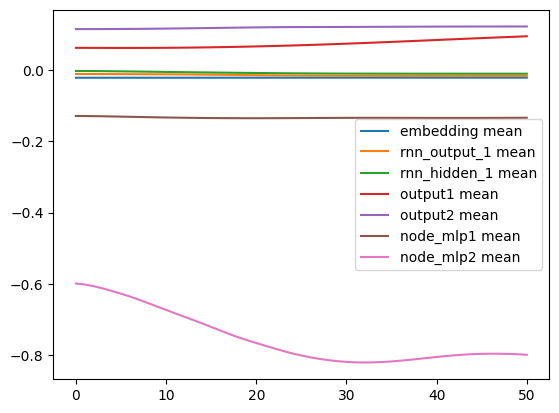

In [ ]:
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

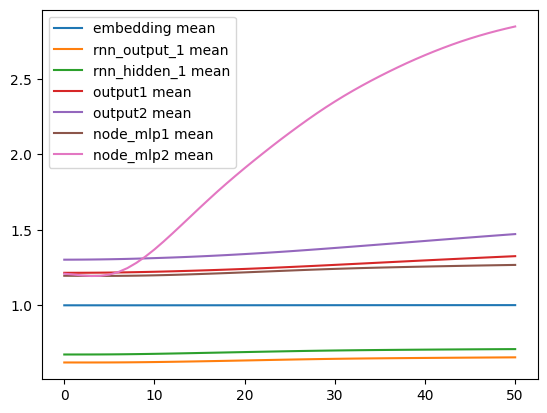

In [ ]:
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')